# Life Expectancy and Hapiness Ranking

## Goal for this Notebook:

In this notebook, data analyis is performed on two different datasets. EDA and data cleansing are also conducted.
Finally, the position of Greece and France among other European countries is examined.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
import math

import sys
sys.path.append("..")

C:\Users\user\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### PDF Reporting 

The PDF_reporting contains all the necessary functions that will be used for the generation of the PDF report that will contain text/ plots from this analysis

In [4]:
from EDA_ML_Package.EDA_functions import Data_Analysis
from EDA_ML_Package.PDF_report import PDF_reporting

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)


PDF = PDF_reporting()


### Data Importing

Combining "Life Expectancy" and Happiness score data from 2015

In [5]:
df = pd.read_csv("Life Expectancy Data.csv")

data = pd.read_csv('2015.csv')
data = data[['Country', 'Region', 'Happiness Rank', 'Happiness Score']]
data['Year'] = 2015

df = pd.merge(df, data, how="left", on=["Country", "Year"])


In [6]:
# Cleansing Column names
for clm in df.columns:
    clm_new = clm.replace("-", "_")
    if clm_new[-1] == " ":
        clm_new = clm_new[:-1]
    df = df.rename(columns={clm: clm_new})


## Exploratory Data Analysis

In [7]:
def box_hist_EDA_plots(df, plot_type='boxplot', target_att='', no_rows=-1):
    """Function that generates histogram/ box plots for the numerical attributes
    and count for the object attributes"""
    def plot_hist():
        hist_list = []
        labels_list = []
        values_list = df_copy[target_att].unique().tolist()
        values_list.sort()
        for i, val in enumerate(values_list):
            # plt.hist(df_copy.loc[df_copy[target_att] == val, col].values, **kwargs, label=str(val), color=colors[i])
            hist_list.append(df_copy.loc[df_copy[target_att] == val, col].values)
            labels_list.append(str(val))

        plt.hist(hist_list, **kwargs, label=labels_list, color=colors[0:len(hist_list)])
        plt.xticks(fontsize=12)
        plt.legend()

    df_copy = df.copy()

    # find optimum number of rows if not given
    if no_rows == -1:
        no_rows = divmod(len(df_copy.columns), 10)[0]

    # figure quality
    fig = plt.figure(figsize=(25, 5*no_rows))

    kwargs = dict(alpha=0.5, bins=20)  # , density=True, stacked=False)
    colors = ['b', 'r', 'g']

    # loop through all attributes
    for i, col in enumerate(df_copy.columns, 1):

        # numerical attributes
        if (df_copy[col].dtype == np.float64 or df_copy[col].dtype == np.int64):
            plt.subplot(no_rows, math.ceil(len(df_copy.columns)/no_rows), i)

            # box plot
            if plot_type == 'boxplot':
                plt.boxplot(df_copy[~df_copy[col].isnull()][col])
                ax = plt.gca()
                ax.axes.xaxis.set_ticklabels([])

            else:  # histogram
                if target_att != '':
                    plot_hist()
                else:
                    plt.hist(df_copy[~df_copy[col].isnull()][col])

            plt.title(col, fontsize=20)

        else:  # object attributes
            plt.subplot(no_rows, math.ceil(len(df_copy.columns)/no_rows), i)

            if len(df_copy[col].unique()) <= 15:
                if target_att != '':  # class histogram
                    df_copy[col], map_dict = DA.categorise_codes(df_copy, col)
                    plot_hist()
                    plt.text(0.35, 10, str(map_dict), size=15)
                else:  # count plot
                    sp = sns.countplot(x=col, data=df_copy)
                    plt.setp(sp.get_xticklabels(), ha="right", rotation=45, fontsize=10)
                    sp.set(xlabel=None)

            else:  # empty plot
                plt.text(0.35, 0.35, str(len(df_copy[col].unique())) + " unique values", size=15)
                ax = plt.gca()
                ax.axes.xaxis.set_ticklabels([])
            plt.title(col, fontsize=20)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    plt.show()
    return fig



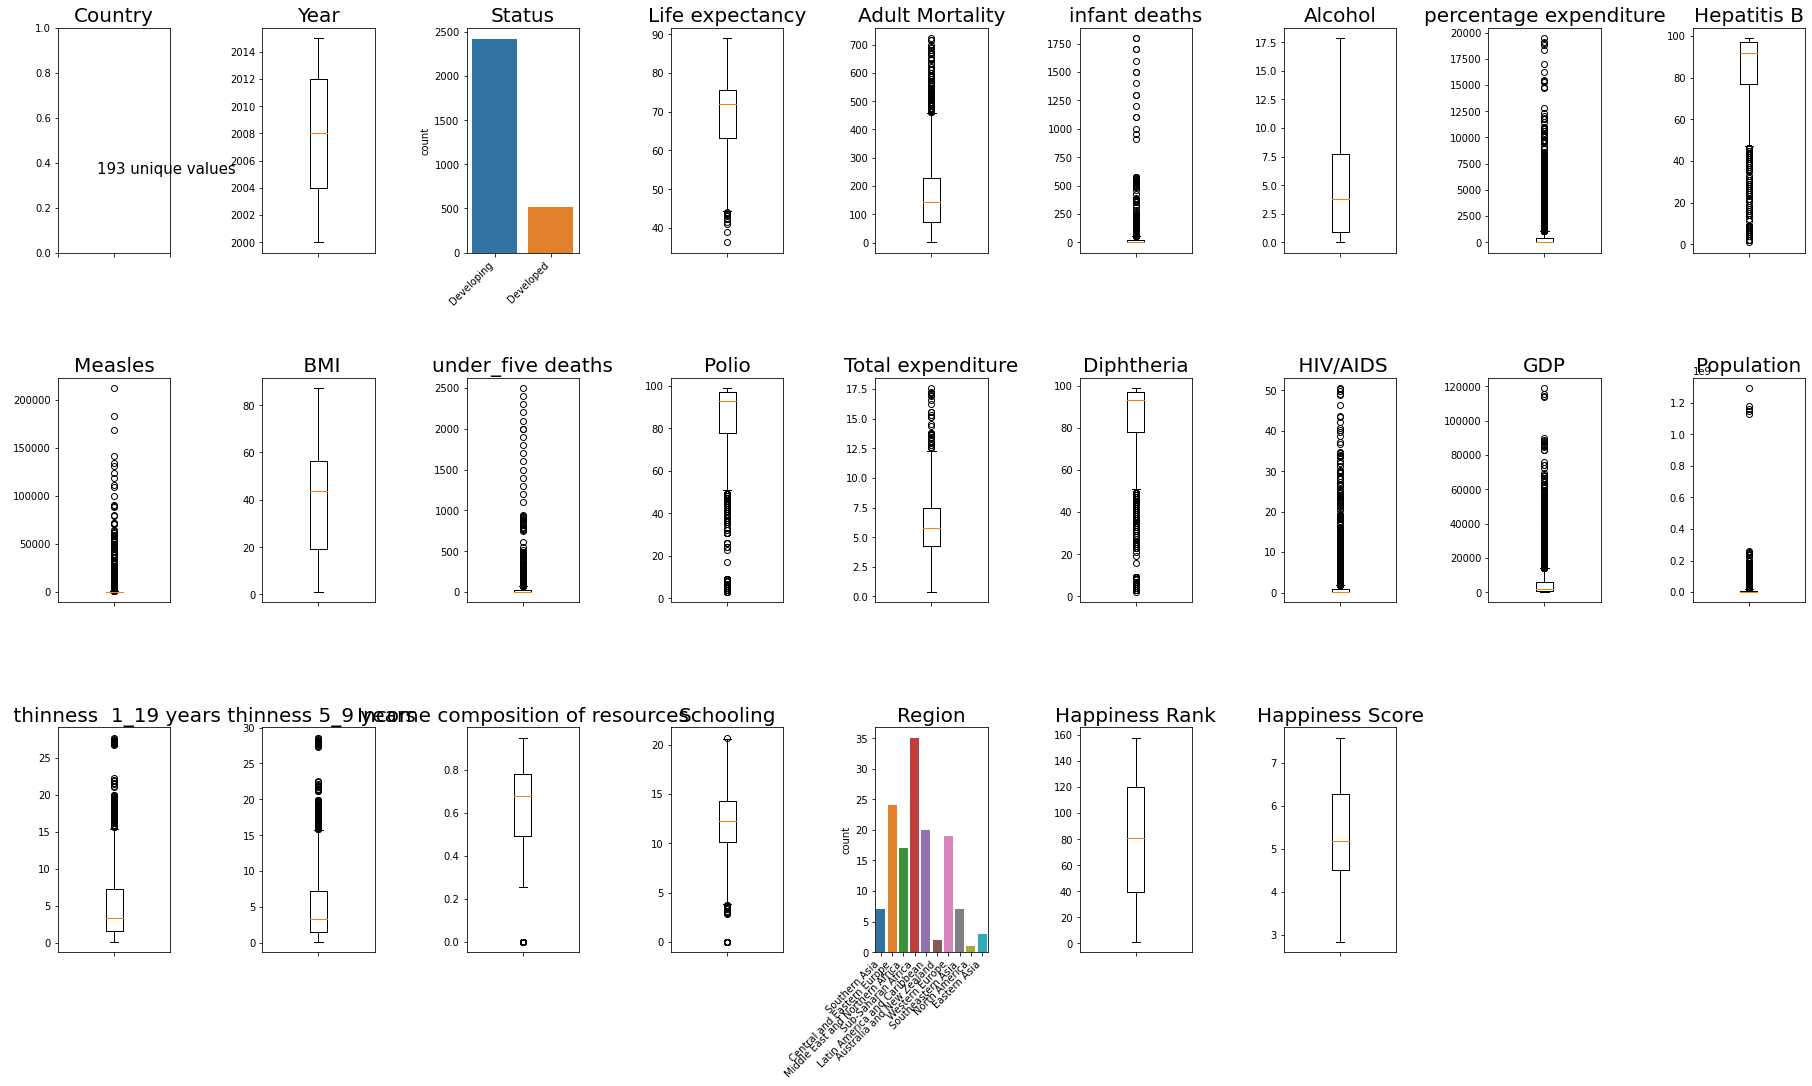

In [8]:
plt_obj = box_hist_EDA_plots(df, no_rows=3)
PDF.add_text("Box Plot", style="Heading1", fontsize=24)
PDF.image_in_PDF(plt_obj, x=7, y=4)

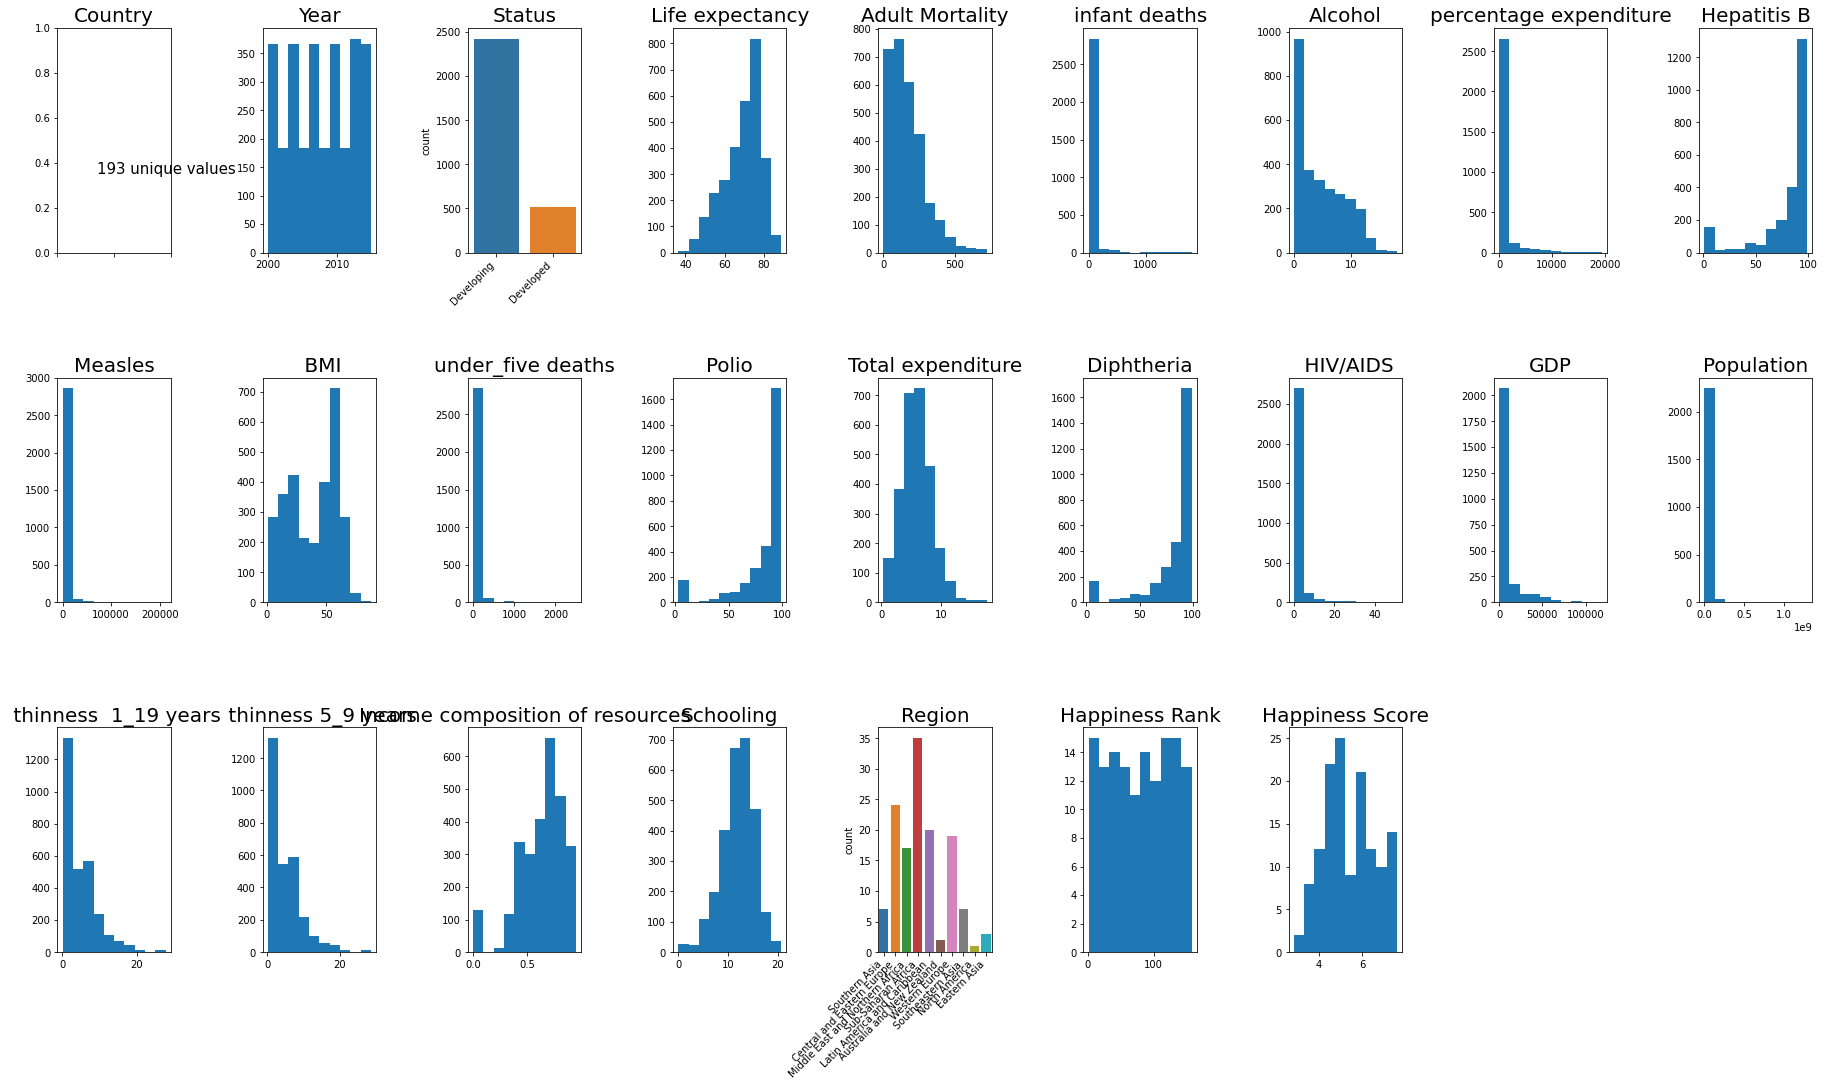

In [9]:
plt_obj = box_hist_EDA_plots(df, 'hist', no_rows=3)
PDF.add_text("Hist Plot", style="Heading1", fontsize=24)
PDF.image_in_PDF(plt_obj, x=7, y=4)

## Feature Analysis

In [14]:
def impute_dataset(df):
    for ctr in df.Country.unique():
        df_country = df[df.Country == ctr]
        for clm in df.columns:
            try:
                df.loc[df.Country == ctr, clm] = df_country[clm].fillna(df_country[clm].dropna().mean())
            except Exception:
                pass

    return df


In [15]:
df = impute_dataset(df)

## Outliers Removal

In the box plots above, a siginificant number of outlers can be observed. With the following function, data that lie outside the 95% are removed

In [16]:
from scipy.stats.mstats import winsorize

def outlier_winsorize(data, list_exclude=[]):
    for col in data.columns:
        if col not in list_exclude:
            try:

                # q75, q25 = np.percentile(data[col], [75, 25])
                q75, q25 = np.percentile(data[~data[col].isnull()][col], [75, 25])
                # q95, q05 = np.percentile(data[col], [95, 5])
                iqr = q75 - q25
                min_val = q25 - (iqr*1.5)
                max_val = q75 + (iqr*1.5)

                outlier_count_lower = len(np.where((data[col] < min_val))[0])
                outlier_count_upper = len(np.where((data[col] > max_val))[0])
                outlier_percent_lower = round(outlier_count_lower/len(data[col])*100, 2)
                outlier_percent_upper = round(outlier_count_upper/len(data[col])*100, 2)
                print(15*'-' + col + 15*'-')
                print('Number of outliers lower: {}'.format(outlier_count_lower))
                print('Number of outliers upper: {}'.format(outlier_count_upper))
                print('Percent of data that is outlier lower: {}%'.format(outlier_percent_lower))
                print('Percent of data that is outlier upper: {}%'.format(outlier_percent_upper))

                wins_data = winsorize(data[col], limits=(outlier_percent_lower/100, outlier_percent_upper/100))
                data[col] = wins_data
            except Exception:
                pass
    return data

In [17]:
df = outlier_winsorize(df, ['GDP'])  # modify outliers

---------------Year---------------
Number of outliers lower: 0
Number of outliers upper: 0
Percent of data that is outlier lower: 0.0%
Percent of data that is outlier upper: 0.0%
---------------Life expectancy---------------
Number of outliers lower: 10
Number of outliers upper: 0
Percent of data that is outlier lower: 0.34%
Percent of data that is outlier upper: 0.0%
---------------Adult Mortality---------------
Number of outliers lower: 0
Number of outliers upper: 82
Percent of data that is outlier lower: 0.0%
Percent of data that is outlier upper: 2.79%
---------------infant deaths---------------
Number of outliers lower: 0
Number of outliers upper: 315
Percent of data that is outlier lower: 0.0%
Percent of data that is outlier upper: 10.72%
---------------Alcohol---------------
Number of outliers lower: 0
Number of outliers upper: 0
Percent of data that is outlier lower: 0.0%
Percent of data that is outlier upper: 0.0%
---------------percentage expenditure---------------
Number of 

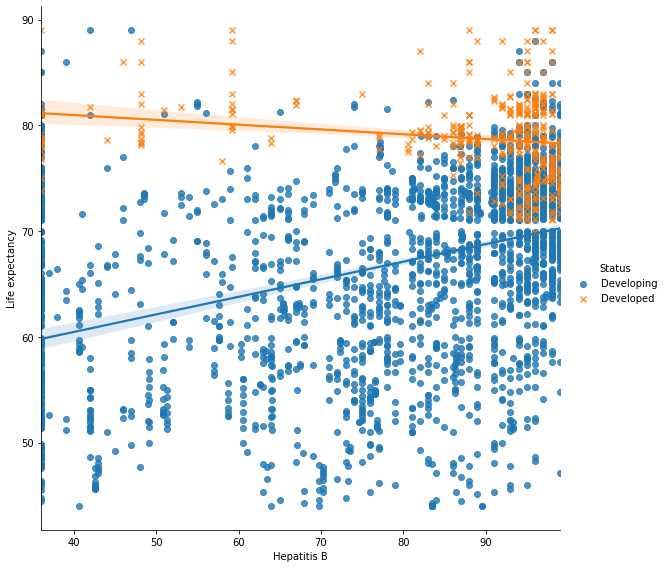

In [18]:
sns.pairplot(df, x_vars=["Hepatitis B"], y_vars=["Life expectancy"],
             hue="Status", markers=["o", "x"], height=8, kind="reg")

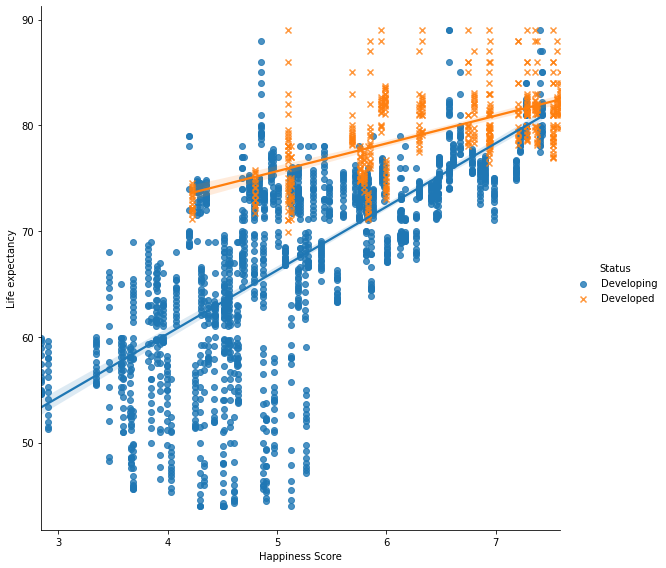

In [19]:
sns.pairplot(df, x_vars=["Happiness Score"], y_vars=["Life expectancy"],
             hue="Status", markers=["o", "x"], height=8, kind="reg")

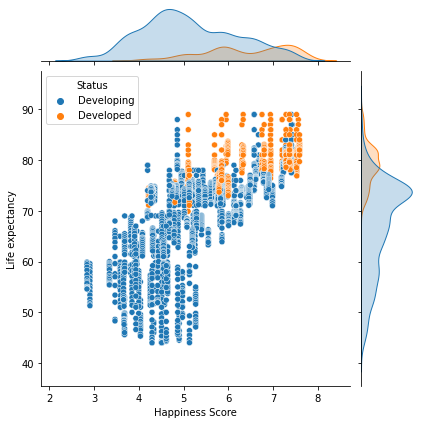

In [20]:
g = sns.jointplot(x=df["Happiness Score"], y=df["Life expectancy"], hue=df["Status"], height=6)
# g = (g.set_axis_labels("Tuition and Fees $","Applications"))

In [21]:
df_region_mean = df.groupby(['Region']).mean()[['Life expectancy', 'Happiness Score']]

<AxesSubplot:xlabel='Happiness Score', ylabel='Region'>

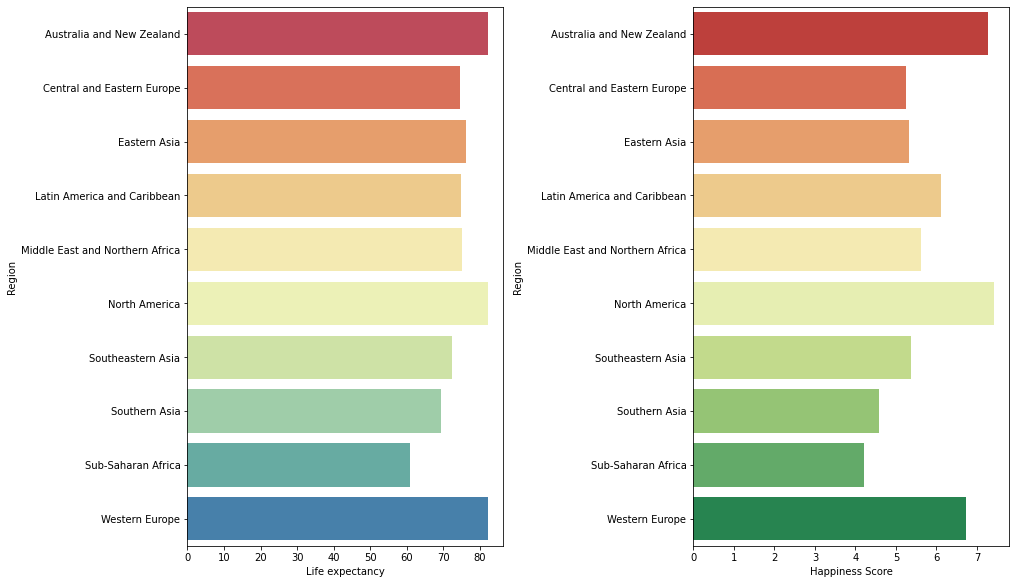

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(14, 8))
sns.barplot(x='Life expectancy', y=df_region_mean.index, data=df_region_mean, ax=axes[0], palette='Spectral')
sns.barplot(x='Happiness Score', y=df_region_mean.index, data=df_region_mean, ax=axes[1], palette='RdYlGn')


# How Happy are people in Greece and France

In [10]:

def spec_country_among_others(countryX, category_field, x=6, y=3):
    colors_blue = ["#132C33", "#264D58", '#17869E', '#51C4D3', '#B4DBE9']
    colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
    colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']

    countryX_region = df[df.Country == countryX]['Region'].dropna().iloc[0]
    df_region = df[df['Region'].str.contains(countryX_region).fillna(False)]

    df_region = df_region.reset_index(drop=True)
    df_region = df_region.sort_values(by=[category_field], ascending=False)
    df_region['Rank'] = list(range(1, len(df_region) + 1))
    country_pos = df_region[df_region['Country'] == countryX]['Rank'].iloc[0]
    # df_countryX = df_region.iloc[country_pos-3:country_pos+3]
    mean_score = df_region[category_field].mean()

    top_bottom_pos = 2
    countries_in_middle = 5
    df_region_top = df_region.head(top_bottom_pos)
    df_region_bot = df_region.tail(top_bottom_pos)
    upper_limit = country_pos-countries_in_middle
    if upper_limit < 0:
        upper_limit = 0
    lower_limit = country_pos+countries_in_middle
    df_region_mid = df_region.iloc[upper_limit:lower_limit]
    df_region_mid = df_region_mid[~df_region_mid.index.isin(df_region_top.index)]
    df_region_mid = df_region_mid[~df_region_mid.index.isin(df_region_bot.index)]

    df_region_filtered = pd.concat([df_region_top, df_region_mid, df_region_bot])
    # df_region_filtered = df_region_filtered.drop_duplicates()
    country_region_pos = df_region_filtered.reset_index()[df_region_filtered.reset_index().Country == countryX].index[0]

    fig, ax = plt.subplots(figsize=(14, 8))
    bars0 = ax.bar(df_region_top['Country'], df_region_top[category_field], color=colors_blue[0], alpha=0.6, edgecolor=colors_dark[0])
    bars1 = ax.bar(df_region_mid['Country'], df_region_mid[category_field], color=colors_dark[3], alpha=0.4, edgecolor=colors_dark[0])
    bars2 = ax.bar(df_region_bot['Country'], df_region_bot[category_field], color=colors_red[0], alpha=0.6, edgecolor=colors_dark[0])
    ax.axhline(mean_score, linestyle='--', color=colors_dark[2])

    (bars0 + bars1 + bars2)[country_region_pos].set_alpha(1)
    (bars0 + bars1 + bars2)[country_region_pos].set_color(colors_red[3])
    (bars0 + bars1 + bars2)[country_region_pos].set_edgecolor(colors_dark[0])

    ax.legend(["Average", "Top", "Other", "Bottom"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, borderpad=1, frameon=False, fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_xlabel("Countries", fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
    ax.set_ylabel(category_field, fontsize=14, labelpad=10, fontweight='bold', color=colors_dark[0])
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    i = 0
    for barX in [bars0, bars1, bars2]:
        for bar in barX:
            x = bar.get_x()
            y = bar.get_height()
            ax.text(
                s=f"{df_region_filtered['Rank'].iloc[i]}th",
                va='center', ha='center',
                x=x+0.38, y=y/2,
                color=colors_blue[0],
                fontsize=14,)
            i += 1

    plot_text = countryX + " is in " + str(df_region_filtered.iloc[country_region_pos].Rank)
    plot_text = plot_text + " position out of " + str(len(df_region)) + " countries in " + countryX_region + "\n"
    plot_text = plot_text + "Category: " + category_field
    plt.text(s=plot_text, ha='left', x=xmin, y=ymax*1.05, fontsize=16, fontweight='bold', color=colors_dark[0])
    # plt.title("How Happy is " + countryX + " in " + countryX_region, loc='left', fontsize=13, color=colors_dark[2])
    plt.tight_layout()
    PDF.image_in_PDF(plt, x=6, y=3)
    plt.show()



The "image_in_PDF" function from the PDF instance is called in the above function. The PDF function "add_text" is called in order text to be added to the PDF.

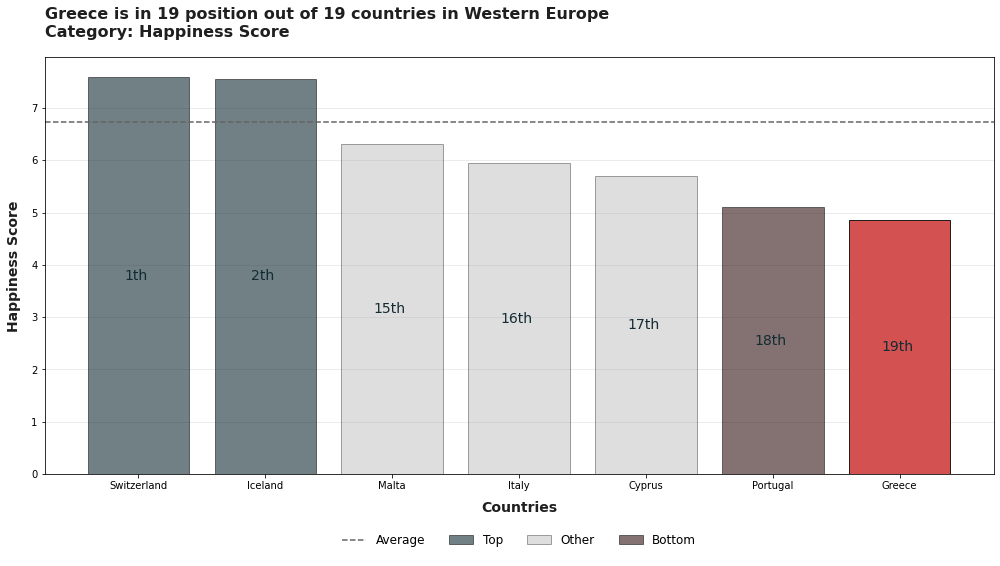

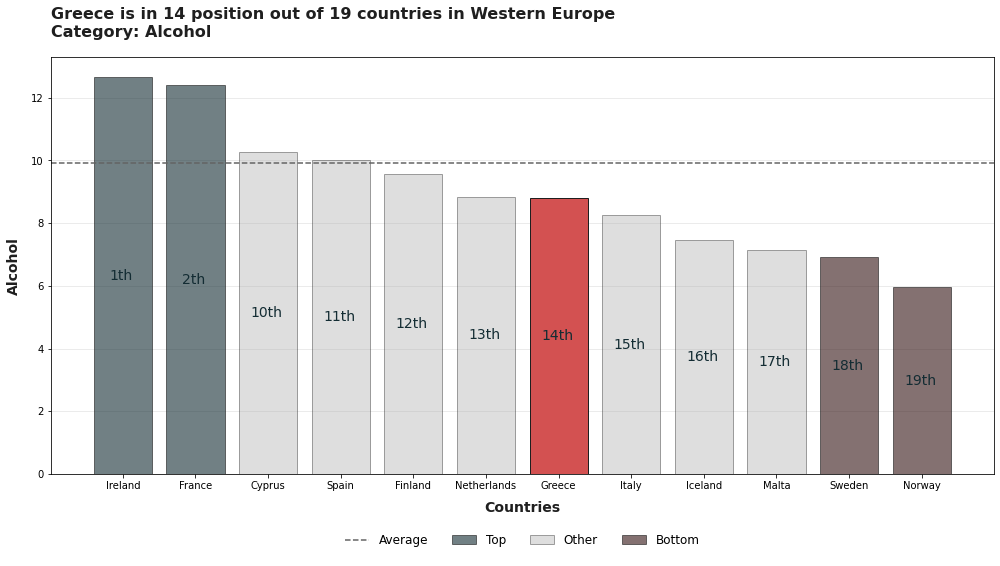

In [24]:
PDF.add_text("Greece In Europe", style="Heading1", fontsize=24, page_break=1)
spec_country_among_others("Greece", "Alcohol", x=7, y=2)
spec_country_among_others("Greece", "Happiness Score", x=7, y=2)
spec_country_among_others("Greece", "Life expectancy", x=7, y=2)
spec_country_among_others("Greece", "Schooling", x=7, y=2)



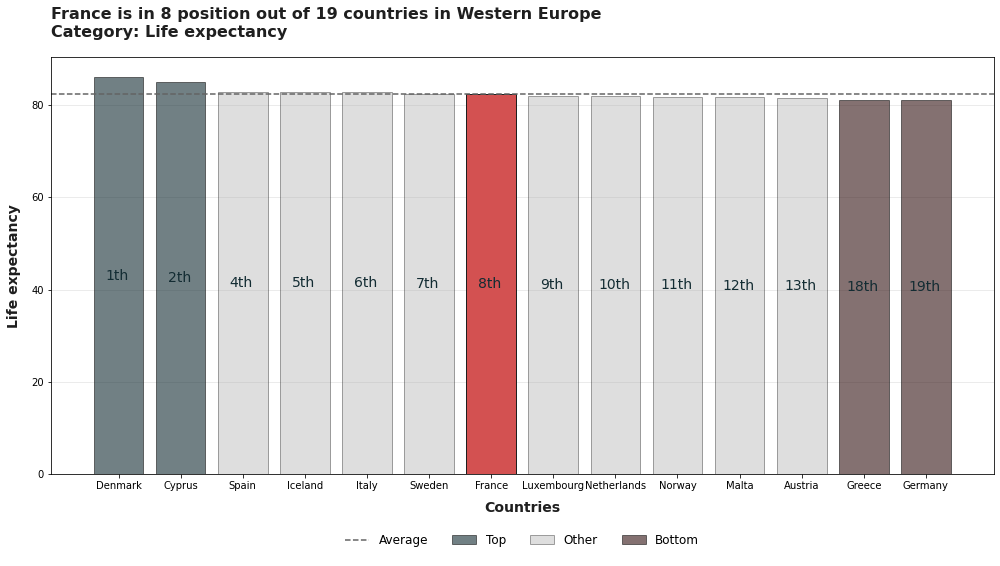

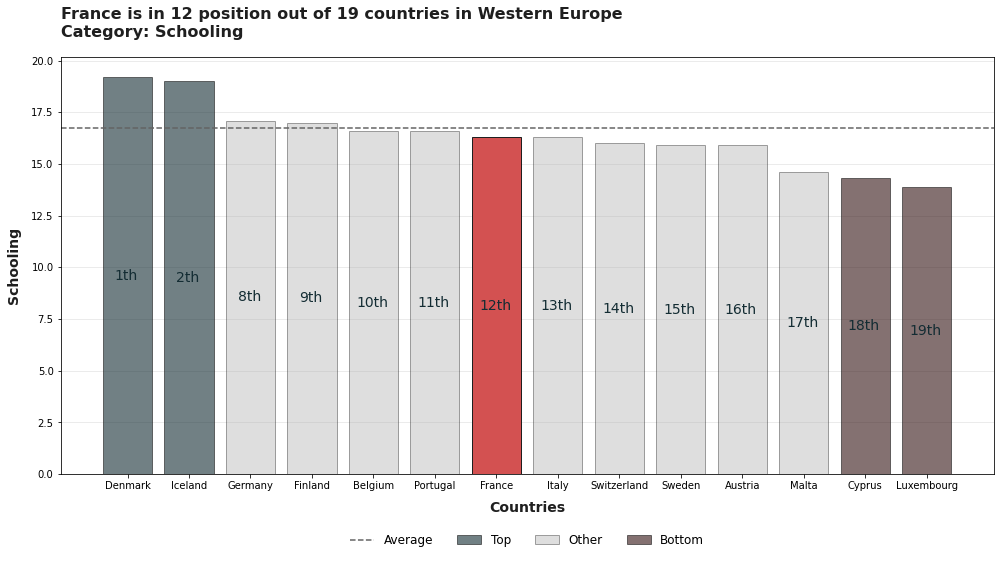

In [25]:
PDF.add_text("France In Western Europe", style="Heading1", fontsize=24, page_break=1)
spec_country_among_others("France", "Schooling", x=7, y=2)
spec_country_among_others("France", "Life expectancy", x=7, y=2)
spec_country_among_others("France", "Life expectancy", x=7, y=2)
spec_country_among_others("France", "Schooling", x=7, y=2)

In [26]:
PDF.generate_report('Life Expectancy')

A PDF file is created in the path of the python file